In [1]:
# Required package for running SQL queries: ipython-sql
# If not installed run: !pip install ipython-sql

# Load sql extention
%load_ext sql

import pandas as pd
import sqlite3

In [2]:
# Load cleaned data
df = pd.read_csv('./unwto_cleaned_long.csv')

# Connect to SQLIte database
conn = sqlite3.connect('tourism.db')


# Save dataframe to SQL table
df.to_sql('tourism_data', conn, if_exists='replace', index=False)

# Load sql extension with this connection
%sql sqlite:///tourism.db

In [3]:
%config SqlMagic.style = '_DEPRECATED_DEFAULT'

#### Data Exploration

In [4]:
%%sql
SELECT * FROM tourism_data LIMIT 5;

 * sqlite:///tourism.db
Done.


Country,Indicator,Year,Value
ALGERIA,Number of rooms,1995,31805.0
ALGERIA,Number of bed-places,1995,63614.0
ALGERIA,Occupancy rate / bed-places,1995,33.34
ANGOLA,Number of rooms,1995,4943.0
ANGOLA,Number of bed-places,1995,6783.0


In [5]:
%%sql
SELECT COUNT(*) AS total_rows, COUNT(DISTINCT Country) AS unique_countries FROM tourism_data;


 * sqlite:///tourism.db
Done.


total_rows,unique_countries
20015,215


#### Find Total Bed-Places Over Time

In [6]:
%%sql

SELECT YEAR, SUM(Value) AS Total_Bed_Places
FROM tourism_data
WHERE Indicator = 'Number of bed-places'
GROUP BY YEAR
ORDER BY YEAR

 * sqlite:///tourism.db
Done.


Year,Total_Bed_Places
1995,15720391.0
1996,16130980.0
1997,16748724.0
1998,17912510.0
1999,18697077.0
2000,19170642.0
2001,19378054.0
2002,19885084.0
2003,20573073.0
2004,21711195.0


In [7]:
# Visualization

In [8]:
result = %sql SELECT YEAR, SUM(Value) AS Total_Bed_Places \
              FROM tourism_data \
              WHERE Indicator = 'Number of bed-places' \
              GROUP BY YEAR \
              ORDER BY YEAR

df_bed_places = result.DataFrame()

 * sqlite:///tourism.db
Done.


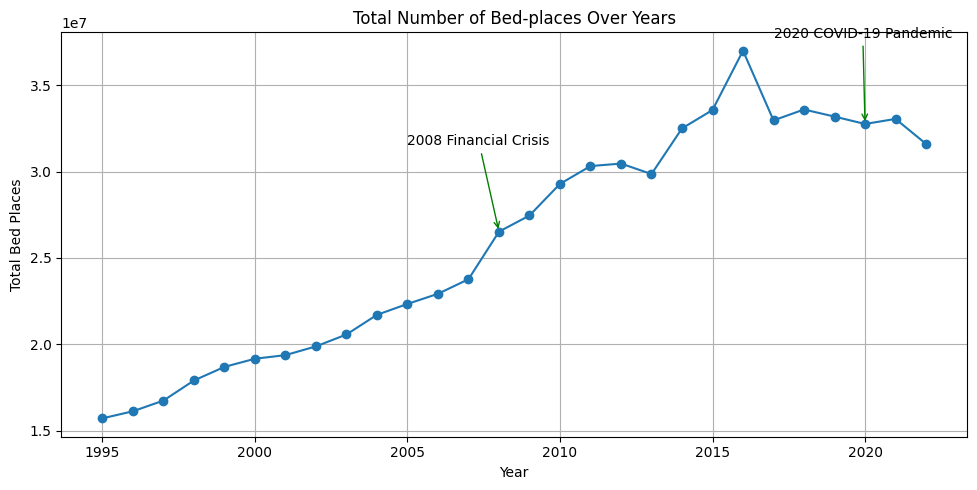

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_bed_places['Year'], df_bed_places['Total_Bed_Places'], marker='o')
plt.title('Total Number of Bed-places Over Years')
plt.xlabel('Year')
plt.ylabel('Total Bed Places')
plt.grid(True)

# Annotation for 2008 Financial Crisis
value_2008 = df_bed_places[df_bed_places['Year'] == 2008]['Total_Bed_Places'].values[0]
plt.annotate('2008 Financial Crisis',
             xy=(2008, value_2008),
             xytext=(2005, value_2008 + 5e6),
             arrowprops=dict(arrowstyle='->', color='green'))

# Annotation for 2020 COVID-19 Pandemic
value_2020 = df_bed_places[df_bed_places['Year'] == 2020]['Total_Bed_Places'].values[0]
plt.annotate('2020 COVID-19 Pandemic',
             xy=(2020, value_2020),
             xytext=(2017, value_2020 + 5e6),
             arrowprops=dict(arrowstyle='->', color='green'))

plt.tight_layout()
plt.show()

In [10]:
import plotly.express as px

fig = px.line(df_bed_places, x='Year', y='Total_Bed_Places',
              title='Total Number of Bed-places Over Years',
              labels={'Year': 'Year', 'Total_Bed_Places': 'Total Bed Places'})

# Add annotations for global events
fig.add_annotation(x=2008, y=df_bed_places[df_bed_places['Year'] == 2008]['Total_Bed_Places'].values[0],
                   text="2008 Financial Crisis",
                   showarrow=True,
                   arrowhead=2,
                   ax=0,
                   ay=-60)

fig.add_annotation(x=2020, y=df_bed_places[df_bed_places['Year'] == 2020]['Total_Bed_Places'].values[0],
                   text="2020 COVID-19 Pandemic",
                   showarrow=True,
                   arrowhead=2,
                   ax=0,
                   ay=-60)


fig.show()


### Insight:
- **1995–2015: Strong Growth Phase**
From 1995 to 2015, there is a steady and significant increase in total bed capacity, almost doubling over two decades.

- This indicates:

    - Growing investment in tourism infrastructure
    - Likely rising demand for accommodations (possibly aligned with increased international arrivals, budget travel, and policy shifts).

- **2015 Peak:**
    - The number of bed-places peaks around 2015–2016.
    - This may reflect a saturation point or a boom in hotel and lodging development.
    - It could also relate to:
        - **Large international events**
        - **Economic optimism**
        - Growth of **alternative accommodations** like hostels and Airbnb listings, depending on how “bed-places” were defined.

- **2017–2023: Gradual Decline**
    - From 2016 onward, the number begins to plateau and then decline.
    - Specially after **2019–2020**, this trend becomes more noticeable, likely due to:
        - The **COVID-19 pandemic**: shutdowns, bankruptcies, and reduced tourism activity
        - Shifts in tourism demand toward **short-term rentals**, **informal stays**, or **reduced capacity for health compliance**
        - **Economic instability**, discouraging new infrastructure investment

#### Growth & Decline Contributors
Top 20 countries contributing to:
- **Growth** in bed-places from 1995 to 2022
- **Decline** in bed-places from 2015 to 2022

In [11]:
%%sql

SELECT
    Country,
    SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) AS Bed_Places_2022,
    SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) AS Bed_Places_1995,
    SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) -
    SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) AS Growth
FROM tourism_data
WHERE Indicator = 'Number of bed-places'
    AND Year IN (1995, 2022)
GROUP BY Country
HAVING Bed_Places_1995 > 0
ORDER BY Growth DESC
LIMIT 20;

 * sqlite:///tourism.db
Done.


Country,Bed_Places_2022,Bed_Places_1995,Growth
TÜRKIYE,1724987.0,280463.0,1444524.0
CHINA,2046700.0,987275.0,1059425.0
MEXICO,1762044.0,740596.0,1021448.0
SPAIN,1992394.0,1074017.0,918377.0
INDONESIA,1169006.0,334856.0,834150.0
COLOMBIA,606446.0,93303.0,513143.0
ITALY,2241988.0,1738031.0,503957.0
GERMANY,1971314.0,1484275.0,487039.0
"IRAN, ISLAMIC REPUBLIC OF",468593.0,41935.0,426658.0
GREECE,880624.0,533812.0,346812.0


In [12]:
# Visualization:
# Assign the result of the SQL query to a variable
growth_result = %sql \
SELECT Country, \
       SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) AS Bed_Places_2022, \
       SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) AS Bed_Places_1995, \
       SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) - \
       SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) AS Growth \
FROM tourism_data \
WHERE Indicator = 'Number of bed-places' \
  AND Year IN (1995, 2022) \
GROUP BY Country \
HAVING Bed_Places_1995 > 0 \
ORDER BY Growth DESC \
LIMIT 20;

# Convert to DataFrame
df_growth = growth_result.DataFrame()

 * sqlite:///tourism.db
Done.


In [13]:
# Visualization with Plotly

fig = px.bar(df_growth,
             x='Growth',
             y='Country',
             orientation='h',
             title='Top 20 Countries by Growth in Bed-Place between 1995 and 2022',
             labels={'Growth':'Growth in Bed-Places', 'Country':'Country'})
fig.update_layout(
    height=800,
    yaxis={'categoryorder':'total ascending'})
fig.show()

#### Insight: Top 20 Countries by Growth in Bed-Places between 1995 and 2022
- **Türkiye** experienced the highest absolute growth, adding ~1.44 million new bed-places. This signals major investment in tourism infrastructure and likely a booming travel sector.
- **China**, **Mexico**, **Spain**, and **Indonesia** follow closely, each with >800K net increase in bed-places — indicating sustained and strategic development in hospitality.
- **Colombia** and **Iran** stand out as non-traditional tourism hotspots with major growth, possibly driven by post-conflict reopening, regional policies, or domestic travel growth.

##### Possible Drivers Behind the Growth
- Emerging economies with increasing middle class and domestic travel (e.g., China, Indonesia, Iran)
- Tourism policy shifts and aggressive marketing (e.g., Türkiye's "Go Türkiye" campaigns)
- Increased foreign investment and hotel chains expanding into developing markets
- Major global events (like Olympics, Expo, World Cup bids) prompting infrastructure buildout

##### Geographic Observations
The majority of top-growing countries are:
- Non-Western or developing economies
- Geographically diverse (Asia, Europe, Latin America, MENA)
- Western Europe (Spain, Germany, Italy, Portugal, Netherlands) still shows growth but at a slower pace, suggesting more mature markets.

###### Further steps for analysis:
- Normalize by population (growth per capita)
- Calculate % change instead of absolute
- Add regional breakdowns (e.g., by continent)
- Create a combined growth vs occupancy insight dashboard






In [14]:
# Break down the growth into two periods from 1995 to 2015 and from 2015 to 2022 to have more realistic analysis considering fast-space changes in recent years

growth_1st_period = %sql \
SELECT Country, \
        SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) AS Bed_Places_1995, \
        SUM(CASE WHEN Year = 2015 THEN Value ELSE 0 END) AS Bed_Places_2015, \
        SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) - \
        SUM(CASE WHEN Year = 2015 THEN Value ELSE 0 END) AS Growth_1995_2015 \
FROM tourism_data \
WHERE Indicator = 'Number of bed-places' \
    AND Year IN(1995,2015) \
GROUP BY Country \
HAVING Bed_Places_1995 > 0 \
ORDER BY Growth_1995_2015 DESC \
LIMIT 20;


 * sqlite:///tourism.db
Done.


In [15]:
# Convert to DataFrame
df_growth_1st = growth_1st_period.DataFrame()

In [19]:
# Visualization of 1st Period
fig = px.bar(df_growth_1st,
             x='Growth_1995_2015',
             y='Country',
             orientation='h',
             title='Top 20 Countries by Growth in Bed-Places from 1995 to 2015',
             labels={'Growth_1995_2015':'Growth in Bed-Places', 'Country':'Country'})
fig.update_layout(
    height=800,
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

In [18]:
# Growth in 2nd Period
growth_2nd_period = %sql \
SELECT Country, \
        SUM(CASE WHEN Year = 2015 THEN Value ELSE 0 END) AS Bed_Places_2015, \
        SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) AS Bed_Places_2022, \
        SUM(CASE WHEN Year = 2015 THEN Value ELSE 0 END) - \
        SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) AS Growth_2015_2022 \
FROM tourism_data \
WHERE Indicator = 'Number of bed-places' \
    AND Year IN(2015,2022) \
GROUP BY Country \
HAVING Bed_Places_2015 > 0 \
ORDER BY Growth_2015_2022 DESC \
LIMIT 20;

 * sqlite:///tourism.db
Done.


In [20]:
# Visualization of 2nd Period

fig = px.bar(growth_2nd_period,
             x='Growth_2015_2022',
             y='Country',
             orientation='h',
             title='Top 20 Countries by Growth in Bed-Places between 2015 and 2022',
             labels={'Growth_2015_2022':'Growth', 'Country':'Country'})
fig.update_layout(
    height=800,
    yaxis={'categoryorder':'total ascending'}
)
fig.show()

In [19]:
%%sql

SELECT
    Country,
    SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) AS Bed_Places_2022,
    SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) AS Bed_Places_1995,
    SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) -
    SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) AS Decline
FROM tourism_data
WHERE Indicator = 'Number of bed-places'
    AND Year in (1995, 2022)
GROUP BY Country
Having Bed_Places_1995 > 0
ORDER BY Decline ASC
LIMIT 20;

 * sqlite:///tourism.db
Done.


Country,Bed_Places_2022,Bed_Places_1995,Decline
UNITED KINGDOM,0,1050223.0,-1050223.0
AUSTRALIA,0,488629.0,-488629.0
RUSSIAN FEDERATION,0,426102.0,-426102.0
BRAZIL,0,279100.0,-279100.0
UKRAINE,0,172468.0,-172468.0
"VENEZUELA, BOLIVARIAN REPUBLIC OF",0,138399.0,-138399.0
"KOREA, REPUBLIC OF",0,117418.0,-117418.0
INDIA,0,114772.0,-114772.0
VIET NAM,0,97860.0,-97860.0
SOUTH AFRICA,0,94744.0,-94744.0


In [23]:
# Total Decline during the whole sturdy period

decline_result = %sql \
SELECT Country, \
    SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) AS Bed_Places_2022, \
    SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) AS Bed_Places_1995, \
    SUM(CASE WHEN Year = 2022 THEN Value ELSE 0 END) - \
    SUM(CASE WHEN Year = 1995 THEN Value ELSE 0 END) AS Decline \
FROM tourism_data \
WHERE Indicator = 'Number of bed-places' \
    AND Year in (1995, 2022) \
GROUP BY Country \
Having Bed_Places_1995 > 0 \
ORDER BY Decline ASC \
LIMIT 20;

 * sqlite:///tourism.db
Done.


In [25]:
# Visualisation
fig = px.bar(decline_result,
             x='Decline',
             y='Country',
             orientation='h',
             title='Top 20 Countries by Decline in Bed-Places between 1995 and 2022',
             labels={'Decline':'Decline in Bed-Places', 'Country':'Country'})
fig.update_layout(
    height=800,
    yaxis={'categoryorder':'total descending'}
)
fig.show()

#### Find Average Occupancy Rate Over Time

In [18]:
%%sql
SELECT Year, AVG(Value) AS Avg_Occupancy_Rate
FROM tourism_data
WHERE Indicator = 'Occupancy rate / bed-places'
GROUP BY Year
ORDER BY Year;

 * sqlite:///tourism.db
Done.


Year,Avg_Occupancy_Rate
1995,42.72636363636364
1996,44.110113636363636
1997,43.6510989010989
1998,44.32168539325843
1999,41.831
2000,42.64688172043011
2001,43.047111111111114
2002,41.93941860465116
2003,40.353658536585364
2004,42.716329113924054


In [20]:
# Visualization

In [19]:
result = %sql SELECT Year, AVG(Value) AS Avg_Occupancy_Rate \
              FROM tourism_data \
              WHERE Indicator = 'Occupancy rate / bed-places' \
              GROUP BY Year \
              ORDER BY Year;

df_occupancy = result.DataFrame()

 * sqlite:///tourism.db
Done.


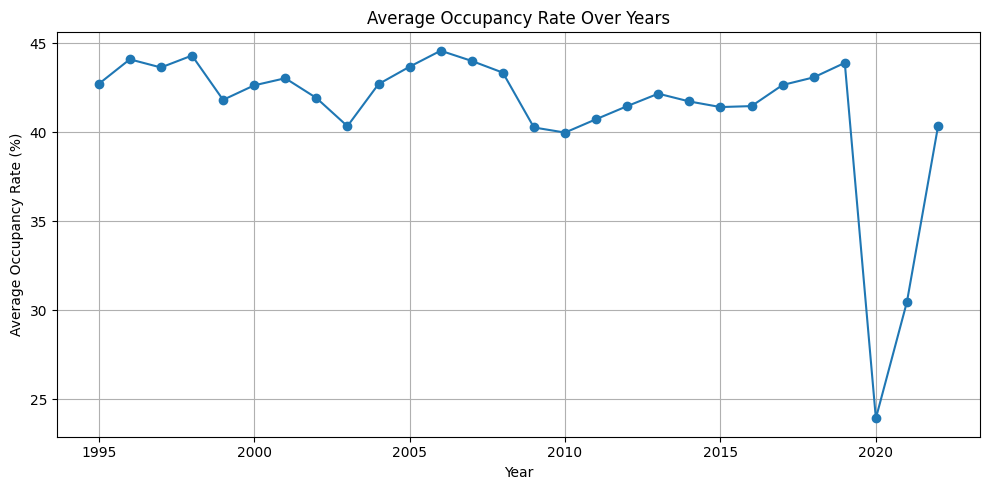

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_occupancy['Year'], df_occupancy['Avg_Occupancy_Rate'], marker='o', linestyle='-')
plt.title('Average Occupancy Rate Over Years')
plt.xlabel('Year')
plt.ylabel('Average Occupancy Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
import plotly.express as px

fig = px.line(df_occupancy, x='Year', y='Avg_Occupancy_Rate',
              title='Average Occupancy Rate Over Years',
              labels={'Year': 'Year', 'Avg_Occupancy_Rate': 'Occupancy Rate (%)'})
fig.show()

#### Top 10 Countries by Bed-Places


In [23]:
%%sql
SELECT Country, Year, Value AS Bed_Places
FROM tourism_data
WHERE Indicator = 'Number of bed-places'
  AND Year = (SELECT MAX(Year) FROM tourism_data)
ORDER BY Bed_Places DESC
LIMIT 10;

 * sqlite:///tourism.db
Done.


Country,Year,Bed_Places
JAPAN,2022,4183501.0
ITALY,2022,2241988.0
CHINA,2022,2046700.0
SPAIN,2022,1992394.0
GERMANY,2022,1971314.0
MEXICO,2022,1762044.0
TÜRKIYE,2022,1724987.0
FRANCE,2022,1354728.0
INDONESIA,2022,1169006.0
GREECE,2022,880624.0


##### Visualization

In [24]:
result = %sql SELECT Country, Year, Value AS Bed_Places \
              FROM tourism_data \
              WHERE Indicator = 'Number of bed-places' \
                AND Year = (SELECT MAX(Year) FROM tourism_data) \
              ORDER BY Bed_Places DESC \
              LIMIT 10;

df_top_beds = result.DataFrame()


 * sqlite:///tourism.db
Done.


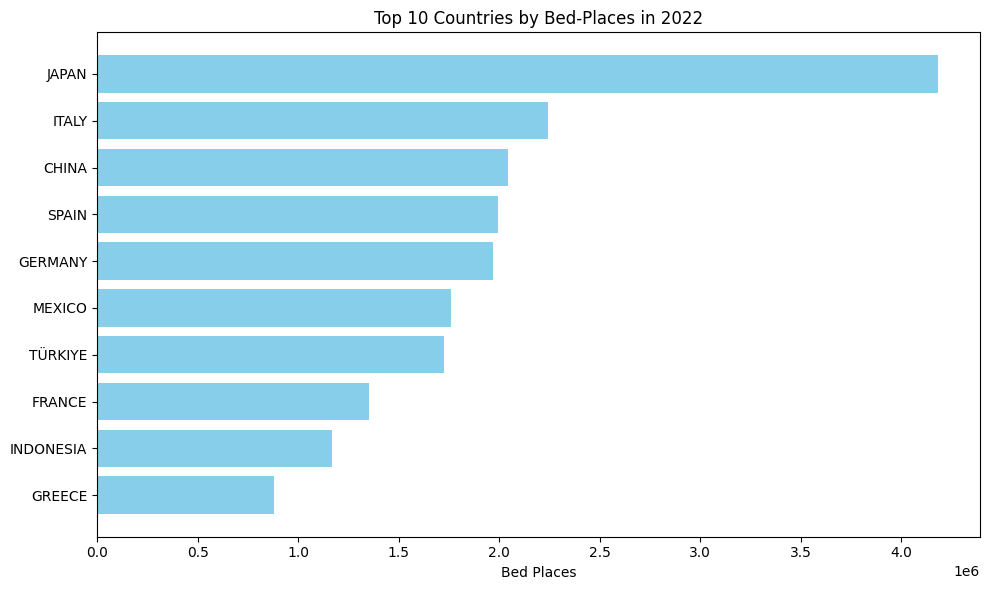

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(df_top_beds['Country'], df_top_beds['Bed_Places'], color='skyblue')
plt.xlabel('Bed Places')
plt.title(f"Top 10 Countries by Bed-Places in {df_top_beds['Year'][0]}")
plt.gca().invert_yaxis()  # To show the highest value at the top
plt.tight_layout()
plt.show()


In [26]:
import plotly.express as px

fig = px.bar(df_top_beds, x='Bed_Places', y='Country',
             orientation='h',
             title=f"Top 10 Countries by Bed-Places in {df_top_beds['Year'][0]}",
             labels={'Bed_Places': 'Number of Bed Places', 'Country': 'Country'})
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


#### Change in Bed-Places (1995 vs Most Recent Year)

In [28]:
%%sql
SELECT Country, Year, Value AS Bed_Places
FROM tourism_data
WHERE Indicator = 'Number of bed-places'
  AND Year IN (1995, (SELECT MAX(Year) FROM tourism_data))
  AND Country IN (
    SELECT Country
    FROM tourism_data
    WHERE Indicator = 'Number of bed-places'
    GROUP BY Country
    HAVING COUNT(DISTINCT Year) >= 2
  )
ORDER BY Bed_Places, Year;

 * sqlite:///tourism.db
Done.


Country,Year,Bed_Places
CENTRAL AFRICAN REPUBLIC,1995,370.0
SAO TOME AND PRINCIPE,1995,404.0
KIRIBATI,2022,535.0
DJIBOUTI,1995,545.0
MARSHALL ISLANDS,1995,658.0
CHAD,1995,688.0
COMOROS,1995,784.0
SAN MARINO,1995,1172.0
LIECHTENSTEIN,1995,1203.0
LIECHTENSTEIN,2022,1215.0


In [29]:
result = %sql SELECT Country, Year, Value AS Bed_Places \
              FROM tourism_data \
              WHERE Indicator = 'Number of bed-places' \
                AND Year IN (1995, (SELECT MAX(Year) FROM tourism_data)) \
                AND Country IN ( \
                    SELECT Country \
                    FROM tourism_data \
                    WHERE Indicator = 'Number of bed-places' \
                    GROUP BY Country \
                    HAVING COUNT(DISTINCT Year) >= 2 \
                ) \
              ORDER BY Bed_Places, Year;

df_beds_compare = result.DataFrame()


 * sqlite:///tourism.db
Done.


In [30]:
df_pivot = df_beds_compare.pivot(index='Country', columns='Year', values='Bed_Places').dropna()
df_pivot = df_pivot.sort_values(by=df_pivot.columns[-1], ascending=False).head(10)  # Top 10 by latest year


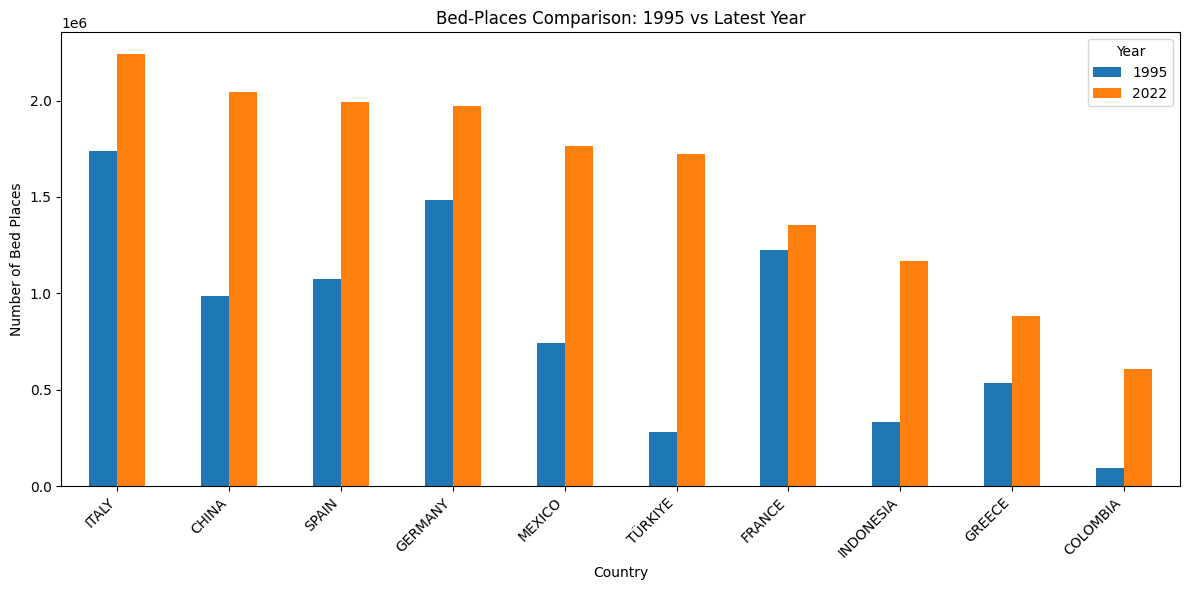

In [31]:
df_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Bed-Places Comparison: 1995 vs Latest Year')
plt.xlabel('Country')
plt.ylabel('Number of Bed Places')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year')
plt.tight_layout()
plt.show()


In [32]:
import plotly.graph_objects as go

fig = go.Figure()
years = df_pivot.columns.tolist()

fig.add_trace(go.Bar(x=df_pivot.index, y=df_pivot[years[0]],
                     name=str(years[0])))
fig.add_trace(go.Bar(x=df_pivot.index, y=df_pivot[years[1]],
                     name=str(years[1])))

fig.update_layout(barmode='group',
                  title='Top 10 Countries: Bed-Places in 1995 vs Latest Year',
                  xaxis_title='Country',
                  yaxis_title='Number of Bed Places')
fig.show()
